## import

In [1]:
import pandas as pd
import numpy as np
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import re
import seaborn as sns
%matplotlib inline
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale

score1 = pd.read_csv("score_1694_final.csv", encoding="cp949")
score2 = pd.read_csv("dasolabutaghe.csv", encoding="cp949")
review1 = pd.read_csv("jaeseok_data.csv", encoding="cp949")

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 데이터 전처리

In [5]:
def preprocessiong(score):
    score["관심인원"] = score["글쎄요"] + score["보고싶어요"]
    score["기대지수"] = (score["보고싶어요"]+ 1) / (score["관심인원"] + 2)
    
    genre_unique = np.unique([b for a in score["장르"] for b in a])
    k = [i.replace("[","") for i in score["장르"]]
    k = [i.replace("]","") for i in k]
    k = [i.replace("'","") for i in k]
    k = [i.replace(" ","") for i in k]
    k = [i.replace('"',"") for i in k]
    k = [i.split(",") for i in k] 

    genre_unique = np.unique([j for i in k for j in i if len(j) >=2])
    
    result = []
    for b in score["장르"]:
        d=[]
        for a in genre_unique:
            d.append(int(a in b))
        result.append(d)
    genre_dummy = pd.DataFrame(result, columns=genre_unique)
    
    score["등급"] = score["등급"].fillna("전체")
    score["등급"] = LabelEncoder().fit_transform(score["등급"])
    num_cols = score["등급"].max()
    
    for i in range(num_cols):
        col_name = '등급' + '_' + str(i)
        score[col_name] = score['등급'].apply(lambda x: 1 if x == i else 0)
    
    return score, genre_dummy

In [6]:
score1, dummy = preprocessiong(score1)
score1.index = [i for i in range(len(score1))]
score1 = score1.join(dummy)

In [7]:
def delete(score):
    del score["Unnamed: 0"]
    del score["Unnamed: 0.1"]
    del score["장르"]
    del score["개봉일"]
    del score["title"]
    del score["등급"]
delete(score1)

In [8]:
review = score2.drop(score2.columns[:38],axis=1)
count_data = pd.concat([score1, review], 'same')
count_data.index = [i for i in range(len(count_data))]

## X와 y 나누기

In [9]:
y = count_data["y"]
X = count_data.drop("y", axis=1)

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

In [10]:
from sklearn.cross_validation import train_test_split

train_X, test_X = train_test_split(X, random_state=1) # 독립변수만
train_Y, test_Y = train_test_split(y, random_state=1) # 종속변수만
print(len(train_X), len(test_X))

1266 423


In [234]:
kfold = 10

## 랜덤 포레스트 GridSearchCV

In [16]:
#learned_parameters = model.best_params_ 
learned_parameters ={'criterion': 'entropy',
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 10}

#= {'criterion': 'entropy',
# 'max_depth': 11,
# 'max_features': 'sqrt',
# 'min_samples_leaf': 4,
# 'min_samples_split': 2,
# 'n_estimators': 10}

In [17]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth = learned_parameters["max_depth"]
                            ,max_features = learned_parameters['max_features']
                            ,min_samples_leaf = learned_parameters['min_samples_leaf']
                            ,min_samples_split = learned_parameters['min_samples_split']
                            ,criterion = learned_parameters['criterion']
                            ,n_estimators = 100
                            ,n_jobs = 3
                            ,random_state=1)
rfc.fit(train_X, train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=13, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [15]:
gsRFC = GridSearchCV(rfc ,param_grid = parameters, cv=3, scoring="f1", n_jobs= 4, verbose = 1)
gsRFC.fit(train_X,train_Y)
RFC_best = gsRFC.best_estimator_

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   57.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 2880 out of 2880 | elapsed:  5.3min finished


In [16]:
gsRFC.best_score_

0.5789513968618446

## 정확도(cv=10)

In [18]:
scores_rfc = cross_val_score(estimator=rfc ,X=X, y=y, cv=5, n_jobs=3, scoring="f1")
print('CV accuracy scores: %s' % scores_rfc)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_rfc), np.std(scores_rfc))) 

CV accuracy scores: [ 0.51485149  0.52336449  0.60606061  0.48351648  0.56603774]
CV accuracy: 0.539 +/- 0.043


In [20]:
coef = pd.Series(rfc.feature_importances_, index = train_X.columns).sort_values(ascending=False)

## Ridge

In [23]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

ridge = RidgeCV(alphas = [0.1, 0.3, 1, 3, 6])
ridge.fit(train_X, train_Y)
alpha = ridge.alpha_
print("Best alpha : ", alpha)

ridge = RidgeCV(alphas = [alpha *.6, alpha * .65, alpha * .7,alpha * .75,
                         alpha * .8, alpha * .85, alpha * .9, alpha * .95,
                         alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25,
                         alpha * 1.3, alpha * 1.35, alpha * 1.4], cv=10)
ridge.fit(train_X, train_Y)
alpha = ridge.alpha_
print("Best alpha : ", alpha)
pred_ridge = ridge.predict(test_X)
#print('Accuracy: %.2f' % accuracy_score(test_Y, pred_lasso))

coefs = pd.Series(ridge.coef_, index = train_X.columns)
print("ridge는 변수를 몇개 선택했니? : ", sum(coefs!=0)) 
print("ridge는 변수를 몇개 버렸니? : ", sum(coefs==0))

Best alpha :  7.0
Best alpha :  6.65
ridge는 변수를 몇개 선택했니? :  1039
ridge는 변수를 몇개 버렸니? :  0


In [24]:
from sklearn.metrics import *
pred_ridge = np.where(pred_ridge > 0.5,1,0)
print(classification_report(test_Y,pred_ridge))

             precision    recall  f1-score   support

          0       0.88      0.99      0.93       362
          1       0.71      0.20      0.31        61

avg / total       0.85      0.87      0.84       423



In [ ]:
scores = cross_val_score(estimator=ridge,X=train_X, y=train_Y, cv=10,n_jobs=1, scoring="f1")
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

## Lasso

In [26]:
lasso = LassoCV(alphas = [0.001, 0.003, 0.006, 
                          0.01, 0.03, 0.06, 0.1])
lasso.fit(train_X, train_Y)
alpha = lasso.alpha_
print("Best alpha : ", alpha)

lasso = LassoCV(alphas = [alpha *.6, alpha * .7alpha * .8, alpha * .9, 
                          alpha * 1.1, alpha * 1.2,
                         alpha * 1.3, alpha * 1.4],
               max_iter = 50000, cv=10)
lasso.fit(train_X, train_Y)
alpha = lasso.alpha_
print("Best alpha : ", alpha)
pred_lasso = lasso.predict(test_X)
#print('Accuracy: %.2f' % accuracy_score(test_Y, pred_lasso))

coefs = pd.Series(lasso.coef_, index = train_X.columns)
print("lasso는 변수를 몇개 선택했니? : ", sum(coefs!=0)) 
print("lasso는 변수를 몇개 버렸니? : ",sum(coefs==0)) 

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Best alpha :  0.001


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Best alpha :  0.0006
lasso는 변수를 몇개 선택했니? :  36
lasso는 변수를 몇개 버렸니? :  1003


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [32]:
from sklearn.metrics import *
pred_lasso = np.where(pred_lasso > 0.5,1,0)
print(classification_report(test_Y,pred_lasso))

             precision    recall  f1-score   support

          0       0.88      0.99      0.93       362
          1       0.67      0.16      0.26        61

avg / total       0.84      0.87      0.83       423



In [34]:
#scores = cross_val_score(estimator=lasso,X=X, y=y, cv=5, n_jobs=1, scoring="f1")
#print('CV accuracy scores: %s' % scores)
#print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

## SVM

In [35]:
from sklearn.model_selection import GridSearchCV 

parameters = {'C':[0.001,0.01], 'gamma': [0.001 ,0.01],
             'kernel':['linear', 'rbf']}
svr = svm.SVC()

In [ ]:
svc = GridSearchCV(svr ,param_grid = parameters, cv=5, scoring="f1", n_jobs= 4, verbose = 1)
svc.fit(train_X,train_Y)
svc_best = svc.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
svc_best

In [132]:
clf = svm.SVC(C = 0.001, gamma = 0.01, kernel = "linear")

In [249]:
scores_svc = cross_val_score(estimator=clf ,X=X, y=y, cv=10, n_jobs=3, scoring="f1")
print('CV accuracy scores: %s' % scores_svc)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_svc), np.std(scores_svc))) 

CV accuracy scores: [ 0.38095238  0.26315789  0.36842105  0.27027027  0.28571429  0.33333333
  0.29411765  0.16666667  0.34285714  0.3       ]
CV accuracy: 0.301 +/- 0.059


## AdaBoost

In [43]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001,0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsadaDTC.fit(train_X,train_Y)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=4)]: Done  49 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 1280 out of 1280 | elapsed:   15.9s finished


In [44]:
scores_DTC = cross_val_score(estimator=gsadaDTC ,X=X, y=y, cv=10, n_jobs=3)
print('CV accuracy scores: %s' % scores_DTC)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_DTC), np.std(scores_DTC))) # 7 : 0.726

CV accuracy scores: [ 0.6875      0.5625      0.6875      0.5625      0.46666667  0.6         0.8
  0.46666667  0.6         0.64285714]
CV accuracy: 0.608 +/- 0.097


In [194]:
gsadaDTC.best_score_

0.71052631578947367

## ExtraTrees

In [48]:
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsExtC.fit(train_X,train_Y)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.3min finished


0.72807017543859653

In [49]:
scores_Ext = cross_val_score(estimator=gsExtC ,X=X, y=y, cv=10, n_jobs=3, scoring='f1')
print('CV accuracy scores: %s' % scores_Ext)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_Ext), np.std(scores_Ext))) # 7 : 0.726

CV accuracy scores: [ 0.6875      0.6875      0.875       0.625       0.6         0.46666667
  0.8         0.66666667  0.66666667  0.85714286]
CV accuracy: 0.693 +/- 0.117


## GradientBoost

In [50]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }
`
gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsGBC.fit(train_X,train_Y)

GBC_best = gsGBC.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s


KeyboardInterrupt: 

In [192]:
gsGBC.best_score_

0.61403508771929827

## Plot 그려보기

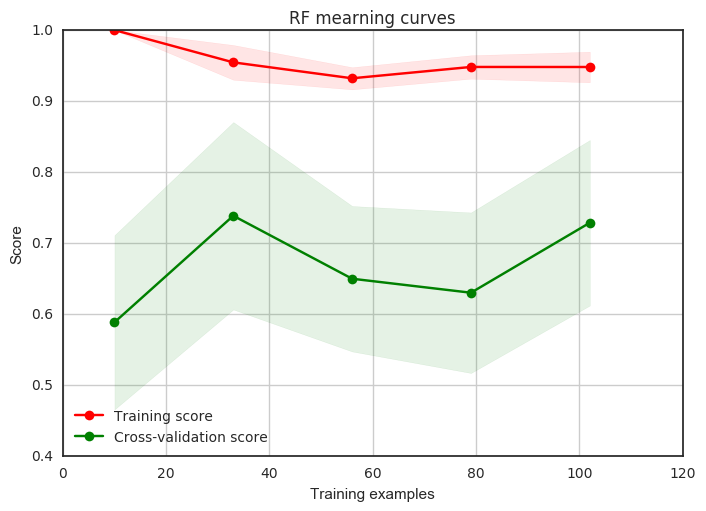

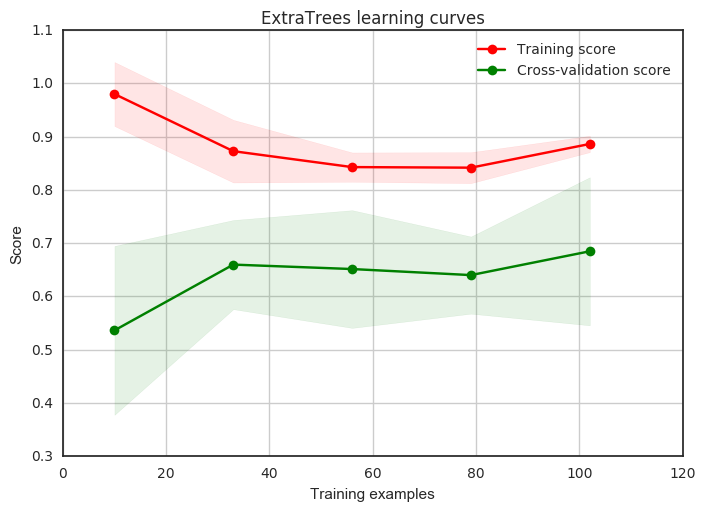

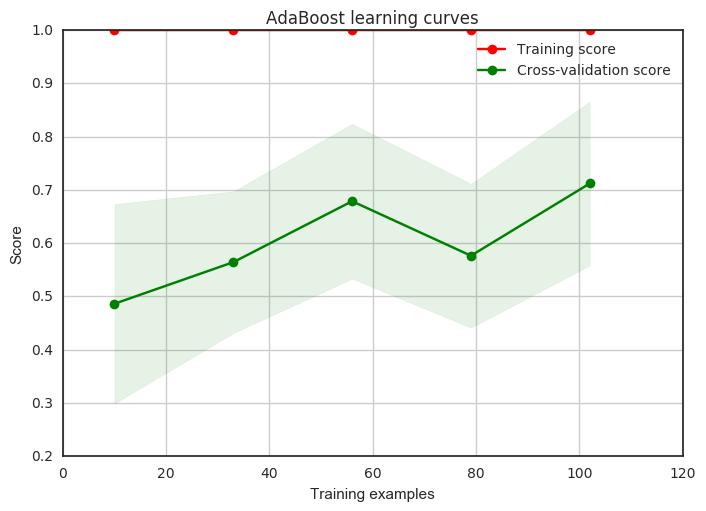

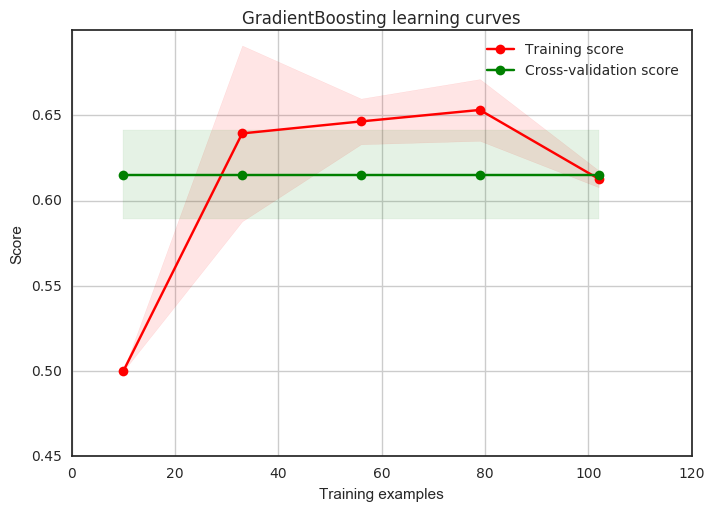

In [179]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",train_X,train_Y,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",train_X,train_Y,cv=kfold)
#g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",train_X,train_Y,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",train_X,train_Y,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",train_X,train_Y,cv=kfold)

## 앙상블

In [189]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(train_X, train_Y)

In [190]:
votingC.fit(X,y)
scores = cross_val_score(estimator=votingC ,X=X, y=y, cv=10, n_jobs=3)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores))) # 0.721

CV accuracy scores: [ 0.8125      0.5         0.875       0.6875      0.66666667  0.46666667
  0.66666667  0.6         0.66666667  0.64285714]
CV accuracy: 0.658 +/- 0.117


## VotingClassifier

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

#tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=1) # 654
knn = KNeighborsClassifier(n_neighbors=6, p=2, metric='minkowski') # 686
ensemble = VotingClassifier(estimators=[('svc', clf), ('rf',rfc), ('knn',knn)], 
                            voting='soft', weights=[ 1, 1, 1])

In [101]:
ensemble.fit(X,y)
scores = cross_val_score(estimator=ensemble ,X=X, y=y, cv=10, n_jobs=3)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores))) # 0.721

JoblibAttributeError: JoblibAttributeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\user\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
C:\Users\user\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x000002AB99DA7810, fil...lib\site-packages\ipykernel\__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__pycache__\__main__.cpython-35.pyc', '__doc__': None, '__file__': r'C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\u...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000002AB99DA7810, fil...lib\site-packages\ipykernel\__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__pycache__\__main__.cpython-35.pyc', '__doc__': None, '__file__': r'C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\u...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "ensemble.fit(X,y)\nscores = cross_val_score(estim....3f' % (np.mean(scores), np.std(scores))) # 0.721", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-01-05T20:37:32.679976', 'msg_id': 'CED9B823A8AD4052827019C60D0AE9CD', 'msg_type': 'execute_request', 'session': '14B8660E95484AAA9DFD05777CF04301', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'CED9B823A8AD4052827019C60D0AE9CD', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'14B8660E95484AAA9DFD05777CF04301']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "ensemble.fit(X,y)\nscores = cross_val_score(estim....3f' % (np.mean(scores), np.std(scores))) # 0.721", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-01-05T20:37:32.679976', 'msg_id': 'CED9B823A8AD4052827019C60D0AE9CD', 'msg_type': 'execute_request', 'session': '14B8660E95484AAA9DFD05777CF04301', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'CED9B823A8AD4052827019C60D0AE9CD', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'14B8660E95484AAA9DFD05777CF04301'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "ensemble.fit(X,y)\nscores = cross_val_score(estim....3f' % (np.mean(scores), np.std(scores))) # 0.721", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-01-05T20:37:32.679976', 'msg_id': 'CED9B823A8AD4052827019C60D0AE9CD', 'msg_type': 'execute_request', 'session': '14B8660E95484AAA9DFD05777CF04301', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'CED9B823A8AD4052827019C60D0AE9CD', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="ensemble.fit(X,y)\nscores = cross_val_score(estim....3f' % (np.mean(scores), np.std(scores))) # 0.721", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "ensemble.fit(X,y)\nscores = cross_val_score(estim....3f' % (np.mean(scores), np.std(scores))) # 0.721"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("ensemble.fit(X,y)\nscores = cross_val_score(estim....3f' % (np.mean(scores), np.std(scores))) # 0.721",), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("ensemble.fit(X,y)\nscores = cross_val_score(estim....3f' % (np.mean(scores), np.std(scores))) # 0.721",)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="ensemble.fit(X,y)\nscores = cross_val_score(estim....3f' % (np.mean(scores), np.std(scores))) # 0.721", store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-101-5e7a127e2d72>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 2ab9d922a90, executio..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000002ABA2A79D20, file "<ipython-input-101-5e7a127e2d72>", line 2>
        result = <ExecutionResult object at 2ab9d922a90, executio..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000002ABA2A79D20, file "<ipython-input-101-5e7a127e2d72>", line 2>, result=<ExecutionResult object at 2ab9d922a90, executio..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000002ABA2A79D20, file "<ipython-input-101-5e7a127e2d72>", line 2>
        self.user_global_ns = {'Counter': <class 'collections.Counter'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nimport re...d_csv("score_fin_38_index.csv", encoding="cp949")', 'df = pd.read_csv("review_38_score.csv", encoding="cp949")\ndf.head()', 'df = pd.read_csv("review_38_score.csv", encoding="cp949")', 'def preprocessiong(score, df):\n    \n    # 참여인원 (... in score["개봉 당일"]]\n    return score, genre_dummy', 'score, dummy = preprocessiong(score,df)\nscore.in...i in range(len(score))]\nscore = score.join(dummy)', 'def delete(score):\n    del score["장르"]\n    del s... score["가족"]\n    del score["index"]\ndelete(score)', 'y = score["y"]\nX = score.drop("y", axis=1)', 'from sklearn.cross_validation import train_test_...state=1) # 종속변수만\nprint(len(train_X), len(test_X))', "#learned_parameters = model.best_params_ \nlearne...,\n# 'min_samples_split': 2,\n# 'n_estimators': 10}", 'from sklearn.ensemble import RandomForestClassif... = 3\n                            ,random_state=1)', 'a = rfc.fit(X,y)', "scores = cross_val_score(estimator=rfc ,X=X, y=y....3f' % (np.mean(scores), np.std(scores))) # 0.716", 'coef = pd.Series(rfc.feature_importances_, index...rain_X.columns).sort_values(ascending=False)\ncoef', "from sklearn.linear_model import LogisticRegress...             voting='soft', weights=[1, 1, 1, 3])", "from sklearn.linear_model import LogisticRegress...             voting='soft', weights=[1, 1, 1, 3])", "from sklearn.linear_model import LogisticRegress...             voting='soft', weights=[1, 1, 1, 3])", "ensemble.fit(X,y)\nscores = cross_val_score(estim....3f' % (np.mean(scores), np.std(scores))) # 0.716", "from sklearn.linear_model import LogisticRegress...             voting='soft', weights=[1, 1, 1, 1])", "ensemble.fit(X,y)\nscores = cross_val_score(estim....3f' % (np.mean(scores), np.std(scores))) # 0.716", ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {2:     movie   bad  good  score  y
0      4등     2 ...0  1119   1712  0
4  강남1970  1180   750    678  0, 13: 개봉 당일        0.116499
보고싶어요        0.078900
관심인원...    0.000542
애니메이션        0.000000
dtype: float64, 28: GridSearchCV(cv=10, error_score='raise',
       ...train_score=True,
       scoring=None, verbose=0), 30: {'p': 6}, 46: GridSearchCV(cv=10, error_score='raise',
       ...train_score=True,
       scoring=None, verbose=0), 47: {'criterion': 'entropy', 'max_depth': 11, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10}, 49: RandomForestClassifier(bootstrap=True, class_wei...lse, random_state=1, verbose=0, warm_start=False), 61: RandomForestClassifier(bootstrap=True, class_wei...lse, random_state=1, verbose=0, warm_start=False), 63: 개봉 당일        0.116499
보고싶어요        0.078900
관심인원...    0.000542
애니메이션        0.000000
dtype: float64, 64: 개봉 당일    0.116499
보고싶어요    0.078900
관심인원     0.0...쎄요      0.062114
제작비      0.060487
dtype: float64, ...}, 'QuadraticDiscriminantAnalysis': <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, ...}
        self.user_ns = {'Counter': <class 'collections.Counter'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nimport re...d_csv("score_fin_38_index.csv", encoding="cp949")', 'df = pd.read_csv("review_38_score.csv", encoding="cp949")\ndf.head()', 'df = pd.read_csv("review_38_score.csv", encoding="cp949")', 'def preprocessiong(score, df):\n    \n    # 참여인원 (... in score["개봉 당일"]]\n    return score, genre_dummy', 'score, dummy = preprocessiong(score,df)\nscore.in...i in range(len(score))]\nscore = score.join(dummy)', 'def delete(score):\n    del score["장르"]\n    del s... score["가족"]\n    del score["index"]\ndelete(score)', 'y = score["y"]\nX = score.drop("y", axis=1)', 'from sklearn.cross_validation import train_test_...state=1) # 종속변수만\nprint(len(train_X), len(test_X))', "#learned_parameters = model.best_params_ \nlearne...,\n# 'min_samples_split': 2,\n# 'n_estimators': 10}", 'from sklearn.ensemble import RandomForestClassif... = 3\n                            ,random_state=1)', 'a = rfc.fit(X,y)', "scores = cross_val_score(estimator=rfc ,X=X, y=y....3f' % (np.mean(scores), np.std(scores))) # 0.716", 'coef = pd.Series(rfc.feature_importances_, index...rain_X.columns).sort_values(ascending=False)\ncoef', "from sklearn.linear_model import LogisticRegress...             voting='soft', weights=[1, 1, 1, 3])", "from sklearn.linear_model import LogisticRegress...             voting='soft', weights=[1, 1, 1, 3])", "from sklearn.linear_model import LogisticRegress...             voting='soft', weights=[1, 1, 1, 3])", "ensemble.fit(X,y)\nscores = cross_val_score(estim....3f' % (np.mean(scores), np.std(scores))) # 0.716", "from sklearn.linear_model import LogisticRegress...             voting='soft', weights=[1, 1, 1, 1])", "ensemble.fit(X,y)\nscores = cross_val_score(estim....3f' % (np.mean(scores), np.std(scores))) # 0.716", ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {2:     movie   bad  good  score  y
0      4등     2 ...0  1119   1712  0
4  강남1970  1180   750    678  0, 13: 개봉 당일        0.116499
보고싶어요        0.078900
관심인원...    0.000542
애니메이션        0.000000
dtype: float64, 28: GridSearchCV(cv=10, error_score='raise',
       ...train_score=True,
       scoring=None, verbose=0), 30: {'p': 6}, 46: GridSearchCV(cv=10, error_score='raise',
       ...train_score=True,
       scoring=None, verbose=0), 47: {'criterion': 'entropy', 'max_depth': 11, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10}, 49: RandomForestClassifier(bootstrap=True, class_wei...lse, random_state=1, verbose=0, warm_start=False), 61: RandomForestClassifier(bootstrap=True, class_wei...lse, random_state=1, verbose=0, warm_start=False), 63: 개봉 당일        0.116499
보고싶어요        0.078900
관심인원...    0.000542
애니메이션        0.000000
dtype: float64, 64: 개봉 당일    0.116499
보고싶어요    0.078900
관심인원     0.0...쎄요      0.062114
제작비      0.060487
dtype: float64, ...}, 'QuadraticDiscriminantAnalysis': <class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
C:\Users\user\Documents\pycode\프로젝트\<ipython-input-101-5e7a127e2d72> in <module>()
      1 ensemble.fit(X,y)
----> 2 scores = cross_val_score(estimator=ensemble ,X=X, y=y, cv=10, n_jobs=3)
      3 print('CV accuracy scores: %s' % scores)
      4 print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores))) # 0.721

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cross_validation.py in cross_val_score(estimator=VotingClassifier(estimators=[('svc', SVC(C=0.001...obs=1, voting='soft',
         weights=[1, 1, 1]), X=     제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬...0    0      0   0    0  

[153 rows x 33 columns], y=0      0
1      0
2      0
3      0
4      0
5  ...
150    0
151    0
152    1
Name: y, dtype: int64, scoring=None, cv=sklearn.cross_validation.StratifiedKFold(labels=...1], n_folds=10, shuffle=False, random_state=None), n_jobs=3, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
   1576     parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
   1577                         pre_dispatch=pre_dispatch)
   1578     scores = parallel(delayed(_fit_and_score)(clone(estimator), X, y, scorer,
   1579                                               train, test, verbose, None,
   1580                                               fit_params)
-> 1581                       for train, test in cv)
        cv = sklearn.cross_validation.StratifiedKFold(labels=...1], n_folds=10, shuffle=False, random_state=None)
   1582     return np.array(scores)[:, 0]
   1583 
   1584 
   1585 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=3), iterable=<generator object cross_val_score.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=3)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
AttributeError                                     Fri Jan  5 20:41:18 2018
PID: 7188                  Python 3.5.2: C:\Users\user\Anaconda3\python.exe
...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (VotingClassifier(estimators=[('svc', SVC(C=0.001...obs=1, voting='soft',
         weights=[1, 1, 1]),      제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬...0    0      0   0    0  

[153 rows x 33 columns], 0      0
1      0
2      0
3      0
4      0
5  ...
150    0
151    0
152    1
Name: y, dtype: int64, <function _passthrough_scorer>, array([ 15,  17,  18,  19,  20,  21,  22,  23,  ..., 145,
       146, 147, 148, 149, 150, 151, 152]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16]), 0, None, None), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (VotingClassifier(estimators=[('svc', SVC(C=0.001...obs=1, voting='soft',
         weights=[1, 1, 1]),      제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬...0    0      0   0    0  

[153 rows x 33 columns], 0      0
1      0
2      0
3      0
4      0
5  ...
150    0
151    0
152    1
Name: y, dtype: int64, <function _passthrough_scorer>, array([ 15,  17,  18,  19,  20,  21,  22,  23,  ..., 145,
       146, 147, 148, 149, 150, 151, 152]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16]), 0, None, None)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cross_validation.py in _fit_and_score(estimator=VotingClassifier(estimators=[('svc', SVC(C=0.001...obs=1, voting='soft',
         weights=[1, 1, 1]), X=     제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬...0    0      0   0    0  

[153 rows x 33 columns], y=0      0
1      0
2      0
3      0
4      0
5  ...
150    0
151    0
152    1
Name: y, dtype: int64, scorer=<function _passthrough_scorer>, train=array([ 15,  17,  18,  19,  20,  21,  22,  23,  ..., 145,
       146, 147, 148, 149, 150, 151, 152]), test=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, error_score='raise')
   1689                              " numeric value. (Hint: if using 'raise', please"
   1690                              " make sure that it has been spelled correctly.)"
   1691                              )
   1692 
   1693     else:
-> 1694         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = VotingClassifier(estimators=[('svc', SVC(C=0.001...obs=1, voting='soft',
         weights=[1, 1, 1])
        X_test =     제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬영... 0    0      0   0    1  

[16 rows x 33 columns]
        y_test = 0     0
1     0
2     0
3     0
4     0
5     0
...  1
13    1
14    0
16    1
Name: y, dtype: int64
        scorer = <function _passthrough_scorer>
   1695         if return_train_score:
   1696             train_score = _score(estimator, X_train, y_train, scorer)
   1697 
   1698     scoring_time = time.time() - start_time

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cross_validation.py in _score(estimator=VotingClassifier(estimators=[('svc', SVC(C=0.001...obs=1, voting='soft',
         weights=[1, 1, 1]), X_test=    제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬영... 0    0      0   0    1  

[16 rows x 33 columns], y_test=0     0
1     0
2     0
3     0
4     0
5     0
...  1
13    1
14    0
16    1
Name: y, dtype: int64, scorer=<function _passthrough_scorer>)
   1746 def _score(estimator, X_test, y_test, scorer):
   1747     """Compute the score of an estimator on a given test set."""
   1748     if y_test is None:
   1749         score = scorer(estimator, X_test)
   1750     else:
-> 1751         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = <function _passthrough_scorer>
        estimator = VotingClassifier(estimators=[('svc', SVC(C=0.001...obs=1, voting='soft',
         weights=[1, 1, 1])
        X_test =     제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬영... 0    0      0   0    1  

[16 rows x 33 columns]
        y_test = 0     0
1     0
2     0
3     0
4     0
5     0
...  1
13    1
14    0
16    1
Name: y, dtype: int64
   1752     if hasattr(score, 'item'):
   1753         try:
   1754             # e.g. unwrap memmapped scalars
   1755             score = score.item()

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py in _passthrough_scorer(estimator=VotingClassifier(estimators=[('svc', SVC(C=0.001...obs=1, voting='soft',
         weights=[1, 1, 1]), *args=(    제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬영... 0    0      0   0    1  

[16 rows x 33 columns], 0     0
1     0
2     0
3     0
4     0
5     0
...  1
13    1
14    0
16    1
Name: y, dtype: int64), **kwargs={})
    239     return scorer
    240 
    241 
    242 def _passthrough_scorer(estimator, *args, **kwargs):
    243     """Function that wraps estimator.score"""
--> 244     return estimator.score(*args, **kwargs)
        estimator.score = <bound method ClassifierMixin.score of VotingCla...bs=1, voting='soft',
         weights=[1, 1, 1])>
        args = (    제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬영... 0    0      0   0    1  

[16 rows x 33 columns], 0     0
1     0
2     0
3     0
4     0
5     0
...  1
13    1
14    0
16    1
Name: y, dtype: int64)
        kwargs = {}
    245 
    246 
    247 def check_scoring(estimator, scoring=None, allow_none=False):
    248     """Determine scorer from user options.

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py in score(self=VotingClassifier(estimators=[('svc', SVC(C=0.001...obs=1, voting='soft',
         weights=[1, 1, 1]), X=    제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬영... 0    0      0   0    1  

[16 rows x 33 columns], y=0     0
1     0
2     0
3     0
4     0
5     0
...  1
13    1
14    0
16    1
Name: y, dtype: int64, sample_weight=None)
    345         score : float
    346             Mean accuracy of self.predict(X) wrt. y.
    347 
    348         """
    349         from .metrics import accuracy_score
--> 350         return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
        accuracy_score = <function accuracy_score>
        y = 0     0
1     0
2     0
3     0
4     0
5     0
...  1
13    1
14    0
16    1
Name: y, dtype: int64
        self.predict = <bound method VotingClassifier.predict of Voting...bs=1, voting='soft',
         weights=[1, 1, 1])>
        X =     제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬영... 0    0      0   0    1  

[16 rows x 33 columns]
        sample_weight = None
    351 
    352 
    353 ###############################################################################
    354 class RegressorMixin(object):

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\voting_classifier.py in predict(self=VotingClassifier(estimators=[('svc', SVC(C=0.001...obs=1, voting='soft',
         weights=[1, 1, 1]), X=    제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬영... 0    0      0   0    1  

[16 rows x 33 columns])
    213             Predicted class labels.
    214         """
    215 
    216         check_is_fitted(self, 'estimators_')
    217         if self.voting == 'soft':
--> 218             maj = np.argmax(self.predict_proba(X), axis=1)
        maj = undefined
        self.predict_proba = <bound method VotingClassifier._predict_proba of...bs=1, voting='soft',
         weights=[1, 1, 1])>
        X =     제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬영... 0    0      0   0    1  

[16 rows x 33 columns]
    219 
    220         else:  # 'hard' voting
    221             predictions = self._predict(X)
    222             maj = np.apply_along_axis(

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\voting_classifier.py in _predict_proba(self=VotingClassifier(estimators=[('svc', SVC(C=0.001...obs=1, voting='soft',
         weights=[1, 1, 1]), X=    제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬영... 0    0      0   0    1  

[16 rows x 33 columns])
    236         """Predict class probabilities for X in 'soft' voting """
    237         if self.voting == 'hard':
    238             raise AttributeError("predict_proba is not available when"
    239                                  " voting=%r" % self.voting)
    240         check_is_fitted(self, 'estimators_')
--> 241         avg = np.average(self._collect_probas(X), axis=0,
        avg = undefined
        self._collect_probas = <bound method VotingClassifier._collect_probas o...bs=1, voting='soft',
         weights=[1, 1, 1])>
        X =     제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬영... 0    0      0   0    1  

[16 rows x 33 columns]
        self._weights_not_none = [1, 1, 1]
    242                          weights=self._weights_not_none)
    243         return avg
    244 
    245     @property

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\voting_classifier.py in _collect_probas(self=VotingClassifier(estimators=[('svc', SVC(C=0.001...obs=1, voting='soft',
         weights=[1, 1, 1]), X=    제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬영... 0    0      0   0    1  

[16 rows x 33 columns])
    228 
    229         return maj
    230 
    231     def _collect_probas(self, X):
    232         """Collect results from clf.predict calls. """
--> 233         return np.asarray([clf.predict_proba(X) for clf in self.estimators_])
        X =     제작비   글쎄요  런타임  보고싶어요  참여인원    평점  개봉 당일  촬영... 0    0      0   0    1  

[16 rows x 33 columns]
        self.estimators_ = [SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False), RandomForestClassifier(bootstrap=True, class_wei...lse, random_state=1, verbose=0, warm_start=False), KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=6, p=2,
           weights='uniform')]
    234 
    235     def _predict_proba(self, X):
    236         """Predict class probabilities for X in 'soft' voting """
    237         if self.voting == 'hard':

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\voting_classifier.py in <listcomp>(.0=<list_iterator object>)
    228 
    229         return maj
    230 
    231     def _collect_probas(self, X):
    232         """Collect results from clf.predict calls. """
--> 233         return np.asarray([clf.predict_proba(X) for clf in self.estimators_])
        clf.predict_proba = undefined
        clf = SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False)
    234 
    235     def _predict_proba(self, X):
    236         """Predict class probabilities for X in 'soft' voting """
    237         if self.voting == 'hard':

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py in predict_proba(self=SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False))
    585         The probability model is created using cross validation, so
    586         the results can be slightly different than those obtained by
    587         predict. Also, it will produce meaningless results on very small
    588         datasets.
    589         """
--> 590         self._check_proba()
        self._check_proba = <bound method BaseSVC._check_proba of SVC(C=0.00...one, shrinking=True,
  tol=0.001, verbose=False)>
    591         return self._predict_proba
    592 
    593     def _predict_proba(self, X):
    594         X = self._validate_for_predict(X)

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py in _check_proba(self=SVC(C=0.001, cache_size=200, class_weight=None, ...None, shrinking=True,
  tol=0.001, verbose=False))
    552     # probability=False using properties. Do not use this in new code; when
    553     # probabilities are not available depending on a setting, introduce two
    554     # estimators.
    555     def _check_proba(self):
    556         if not self.probability:
--> 557             raise AttributeError("predict_proba is not available when "
    558                                  " probability=False")
    559         if self._impl not in ('c_svc', 'nu_svc'):
    560             raise AttributeError("predict_proba only implemented for SVC"
    561                                  " and NuSVC")

AttributeError: predict_proba is not available when  probability=False
___________________________________________________________________________

In [ ]:
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
#classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
#classifiers.append(GradientBoostingClassifier(random_state=random_state))
#classifiers.append(MLPClassifier(random_state=random_state))
#classifiers.append(KNeighborsClassifier())
#classifiers.append(LogisticRegression(random_state = random_state))
#classifiers.append(LinearDiscriminantAnalysis())

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",train_X,train_Y,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",train_X,train_Y,cv=kfold)
#g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",train_X,train_Y,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",train_X,train_Y,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",train_X,train_Y,cv=kfold)


[0.73285714285714287, 0.60761904761904761, 0.73285714285714287, 0.69321428571428567]


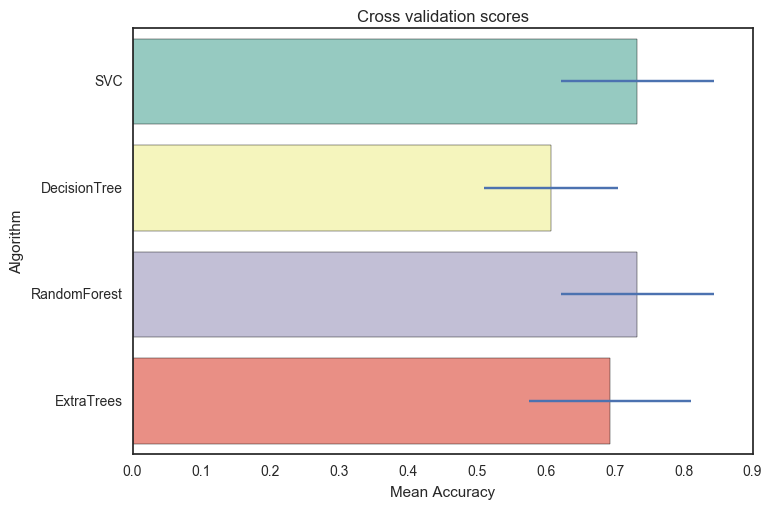

In [54]:
random_state = 0
classifiers = [svc, gsadaDTC, rfc, gsExtC]

cv_results = [scores_rfc, scores_DTC, scores_rfc, scores_Ext]
#for classifier in classifiers :
#    cv_results.append(cross_val_score(classifier, train_X, y = train_Y, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

print( cv_means)
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree",
"RandomForest","ExtraTrees"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


In [51]:
scores_svc

array([ 0.75      ,  0.625     ,  0.8125    ,  0.75      ,  0.8       ,
        0.6       ,  0.73333333,  0.66666667,  0.73333333,  0.85714286])

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(rfc, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

In [ ]:
dot_data = tree.export_graphviz(rfc, out_file=None, 
                         feature_names=X.columns,  
                         class_names=[1,0],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph